In [1]:
%load_ext rpy2.ipython

C:\Users\ChengXin\MyProgram\python\anaconda\pro\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  "The symbol '%s' is not in this R namespace/package." % name


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import urllib

In [3]:
%%R
data_folder = './'
setwd(data_folder)

In [41]:
import re
out_msstats = pd.read_csv("./PXD000279.dynamic.sdrf_openms_design_msstats_in.csv")
def sub_mod(peptide):
    peptide = peptide.replace(".", "")
    peptide = re.sub("\(.*?\)", "", peptide)
    return peptide
    
print(len(out_msstats))
out_msstats["sequence"] = out_msstats.apply(lambda x: sub_mod(x["PeptideSequence"]), axis=1)
filtered_df = out_msstats.groupby('sequence').filter(lambda x: len(set(x["ProteinName"])) == 1)
filtered_df = filtered_df[-filtered_df["ProteinName"].str.contains(";")]
filtered_df = filtered_df.groupby('ProteinName').filter(lambda x: len(set(x["sequence"])) > 2)
filtered_df.drop("sequence", axis=1, inplace=True)
print(len(filtered_df))
filtered_df.to_csv("./PXD000279_no_shared_unique_3.csv", index=False)

187041
183624


In [16]:
len(set(out_msstats[out_msstats["ProteinName"].str.contains("|".join(difference_ups))]["ProteinName"]))

40

In [8]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
# write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-17 14:47:08] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 14:47:08] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 14:47:08] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 14:47:08] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 14:47:08] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 14:47:08] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 14:47:08] ** Shared peptides are removed.
INFO  [2022-09-17 14:47:09] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 14:47:09] ** Features with one or two meas

In [9]:
%%R

ac_groups = levels(quantms.proposed$FeatureLevelData$GROUP)
groups = levels(quantms.proposed$ProteinLevelData$GROUP)
print(ac_groups)

[1] "UPS1" "UPS2"


In [11]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_equalizeMedians.csv")

INFO  [2022-09-17 14:49:43]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 14:50:03]  == Comparisons for all proteins are done.


In [12]:
MSstats_output_equalizeMedians = pd.read_csv("./MSstats_output_equalizeMedians.csv", header=0, sep=",", index_col=0)
MSstats_output_equalizeMedians.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_equalizeMedians[(abs(MSstats_output_equalizeMedians["log2FC"]) >1) &(MSstats_output_equalizeMedians["adj.pvalue"] <0.05) ]
negative = MSstats_output_equalizeMedians[(abs(MSstats_output_equalizeMedians["log2FC"]) <=1) | (MSstats_output_equalizeMedians["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

23
1
2158
16


In [18]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = FALSE,
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
# write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-17 15:03:40] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 15:03:41] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 15:03:41] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 15:03:41] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 15:03:41] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 15:03:41] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 15:03:41] ** Shared peptides are removed.
INFO  [2022-09-17 15:03:41] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 15:03:42] ** Features with one or two meas

In [19]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_NN.csv")

INFO  [2022-09-17 15:04:41]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 15:05:00]  == Comparisons for all proteins are done.


In [21]:
MSstats_output_NN = pd.read_csv("./MSstats_output_NN.csv", header=0, sep=",", index_col=0)
MSstats_output_NN.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) >1) &(MSstats_output_NN["adj.pvalue"] <0.05) ]
negative = MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) <=1) | (MSstats_output_NN["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

7
0
2159
32


In [23]:
%%R -w 800 -h 600

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = "quantile",
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)

INFO  [2022-09-17 15:11:35] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 15:11:35] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 15:11:35] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 15:11:35] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 15:11:35] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 15:11:35] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 15:11:35] ** Shared peptides are removed.
INFO  [2022-09-17 15:11:36] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 15:11:36] ** Features with one or two meas

In [24]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_quantile.csv")

INFO  [2022-09-17 15:12:35]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 15:12:57]  == Comparisons for all proteins are done.


In [25]:
MSstats_output_NN = pd.read_csv("./MSstats_output_quantile.csv", header=0, sep=",", index_col=0)
MSstats_output_NN.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) >1) &(MSstats_output_NN["adj.pvalue"] <0.05) ]
negative = MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) <=1) | (MSstats_output_NN["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

28
1
2158
11


In [38]:
%%R -w 800 -h 600

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = "equalizeMedians",
                                           summaryMethod = 'TMP',
                                           censoredInt = "0",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)

INFO  [2022-09-17 16:16:22] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 16:16:23] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 16:16:23] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 16:16:23] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 16:16:23] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 16:16:23] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 16:16:23] ** Shared peptides are removed.
INFO  [2022-09-17 16:16:23] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 16:16:23] ** Features with one or two meas

In [39]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_0.csv")

INFO  [2022-09-17 16:17:08]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 16:17:26]  == Comparisons for all proteins are done.


In [40]:
MSstats_output_NN = pd.read_csv("./MSstats_output_0.csv", header=0, sep=",", index_col=0)
MSstats_output_NN.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) >1) &(MSstats_output_NN["adj.pvalue"] <0.05) ]
negative = MSstats_output_NN[(abs(MSstats_output_NN["log2FC"]) <=1) | (MSstats_output_NN["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

7
0
2159
32


In [42]:
%%R -w 800 -h 600

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared_unique_3.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = 'equalizeMedians',
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)
# write.csv(Protein.Expression, file=protein_expression, row.names=FALSE)

INFO  [2022-09-17 16:32:16] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 16:32:16] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 16:32:16] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 16:32:16] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 16:32:16] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 16:32:16] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 16:32:16] ** Shared peptides are removed.
INFO  [2022-09-17 16:32:17] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 16:32:17] ** Features with one or two meas

In [43]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_equalizeMedians_unique3.csv")

INFO  [2022-09-17 16:33:10]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 16:33:28]  == Comparisons for all proteins are done.


In [44]:
MSstats_output_equalizeMedians_unique = pd.read_csv("./MSstats_output_equalizeMedians_unique3.csv", header=0, sep=",", index_col=0)
MSstats_output_equalizeMedians_unique.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_equalizeMedians_unique[(abs(MSstats_output_equalizeMedians_unique["log2FC"]) >1) &(MSstats_output_equalizeMedians_unique["adj.pvalue"] <0.05) ]
negative = MSstats_output_equalizeMedians_unique[(abs(MSstats_output_equalizeMedians_unique["log2FC"]) <=1) | (MSstats_output_equalizeMedians_unique["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

27
1
1853
12


In [45]:
%%R -w 800 -h 600

library('MSstats', warn.conflicts = F, quietly = T, verbose = F)

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared_unique_3.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = FALSE,
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]

INFO  [2022-09-17 16:39:18] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 16:39:19] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 16:39:19] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 16:39:19] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 16:39:19] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 16:39:19] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 16:39:19] ** Shared peptides are removed.
INFO  [2022-09-17 16:39:19] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 16:39:19] ** Features with one or two meas

In [46]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_NN_unique3.csv")

INFO  [2022-09-17 16:40:14]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 16:40:30]  == Comparisons for all proteins are done.


In [47]:
MSstats_output_NN_unique3 = pd.read_csv("./MSstats_output_NN_unique3.csv", header=0, sep=",", index_col=0)
MSstats_output_NN_unique3.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_NN_unique3[(abs(MSstats_output_NN_unique3["log2FC"]) >1) &(MSstats_output_NN_unique3["adj.pvalue"] <0.05) ]
negative = MSstats_output_NN_unique3[(abs(MSstats_output_NN_unique3["log2FC"]) <=1) | (MSstats_output_NN_unique3["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

7
0
1854
32


In [48]:
%%R -w 800 -h 600

protein_expression = './protein_expression.csv'

raw.om <- read.csv('./PXD000279_no_shared_unique_3.csv', header = TRUE, sep = ',')
raw.om <- raw.om[!grepl("DECOY", raw.om$ProteinName),]

raw.om <- OpenMStoMSstatsFormat(raw.om)
quantms.proposed <- MSstats::dataProcess(raw = raw.om,
                                           normalization = "quantile",
                                           summaryMethod = 'TMP',
                                           censoredInt = "NA",
                                           MBimpute = TRUE)

# Write the expression protein log values into the expression csv 
head(quantms.proposed$ProteinLevelData)
Protein.Expression <- quantms.proposed$ProteinLevelData[, c('Protein', 'LogIntensities', 'GROUP', 'SUBJECT')]
head(Protein.Expression)

INFO  [2022-09-17 16:42:52] ** Raw data from OpenMS imported successfully.
INFO  [2022-09-17 16:42:53] ** Raw data from OpenMS cleaned successfully.
INFO  [2022-09-17 16:42:53] ** Using annotation extracted from quantification data.
INFO  [2022-09-17 16:42:53] ** Run labels were standardized to remove symbols such as '.' or '%'.
INFO  [2022-09-17 16:42:53] ** The following options are used:
  - Features will be defined by the columns: PeptideSequence, PrecursorCharge, FragmentIon, ProductCharge
  - Shared peptides will be removed.
  - Proteins with single feature will not be removed.
  - Features with less than 3 measurements across runs will be removed.
INFO  [2022-09-17 16:42:53] ** Features with all missing measurements across runs are removed.
INFO  [2022-09-17 16:42:53] ** Shared peptides are removed.
INFO  [2022-09-17 16:42:53] ** Multiple measurements in a feature and a run are summarized by summaryforMultipleRows: max
INFO  [2022-09-17 16:42:53] ** Features with one or two meas

In [49]:
%%R

comparison_matrix = c(1, -1)
comparison <- matrix(comparison_matrix, nrow=1)

colnames(comparison) <- groups[order(as.numeric(groups))]
row.names(comparison) <- "UPS1-UPS2"

ResultComparison <- groupComparison(contrast.matrix=comparison, data=quantms.proposed)
head(ResultComparison$ComparisonResult)

write.csv(ResultComparison$ComparisonResult, file="MSstats_output_quantile_unique3.csv")

INFO  [2022-09-17 16:43:46]  == Start to test and get inference in whole plot ...
  |======================================================================| 100%
INFO  [2022-09-17 16:44:02]  == Comparisons for all proteins are done.


In [50]:
MSstats_output_quantile_unique3 = pd.read_csv("./MSstats_output_quantile_unique3.csv", header=0, sep=",", index_col=0)
MSstats_output_quantile_unique3.dropna(subset=["log2FC", "pvalue"], how="any", inplace=True)
positive =  MSstats_output_quantile_unique3[(abs(MSstats_output_quantile_unique3["log2FC"]) >1) &(MSstats_output_quantile_unique3["adj.pvalue"] <0.05) ]
negative = MSstats_output_quantile_unique3[(abs(MSstats_output_quantile_unique3["log2FC"]) <=1) | (MSstats_output_quantile_unique3["adj.pvalue"] >=0.05) ]

no_difference_ups = ["P00167", "P01133", "P02144", "P04040", "P15559", "P62937", "P63165",  "Q06830"]

difference_ups =  ["P01579", "O76070", "P63279", "P68871","P01127", "P01008", "P62988", "P10599", "P02787", "P99999", "P12081", "P51965","P10636-8", 
       "P01031", "P09211", "P02788", "P41159", "O00762", "P05413", "P00441", "P00918", "P08758", "P00915", "P01344", "P69905", 
        "P00709", "P55957", "P08263", "P61769", "P10145", "P16083", "P61626", "P02741", "P06732",
        "P01375", "P06396", "P02753", "P01112", "Q15843", "P02768"]

TP = len(positive[positive["Protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["Protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

29
1
1853
10


### Proteus

In [29]:
import re
from collections import Counter

def clean_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    pep_seq = pep_seq.replace(".", "")
    return pattern.sub("", pep_seq)

def modified_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t_pep_seq = pep_seq.replace(".", "").replace("Acetyl", "ac").replace("Carbamidomethyl", "ca").replace("Oxidation", "ox")
    t_pep_seq = "_" + t_pep_seq + "_"

def get_modifications(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t = ""
    modifications = re.findall(pattern, pep_seq)
    if len(modifications) == 0:
        return "Unmodified"
    c = Counter(modifications)
    for key, value in c.items():
        if value == 1:
            c[key] = ""
        else:
            c[key] = str(c[key]) + " "
    modifications = ",".join(set(modifications))
    if "(Acetyl)" in c:
        modifications = modifications.replace("(Acetyl)", c["(Acetyl)"] + "Acetyl (Protein N-term)")
    if "(Carbamidomethyl)" in c:
        modifications = modifications.replace("(Carbamidomethyl)", c["(Carbamidomethyl)"] + "Carbamidomethyl (C)")
    if "(Oxidation)" in c:
        modifications = modifications.replace("(Oxidation)", c["(Oxidation)"] + "Oxidation (M)")
        
    return modifications

def get_experiment(row):
    return "_".join(row["Reference"].split(".")[0].split("_")[-2:])

evi = pd.DataFrame(None, columns=['sequence', 'modified_sequence', 'modifications', 'protein_group', 
                                  'protein', 'experiment', 'charge', 'reverse', 'contaminant', 'intensity'])
quantms = pd.read_csv("./PXD000279_no_shared.csv", sep=',', header=0)

quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
evi['sequence'] = quantms.apply(lambda x: clean_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modified_sequence'] = quantms.apply(lambda x: modified_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modifications'] = quantms.apply(lambda x: get_modifications(x['PeptideSequence']), axis=1)
evi['protein_group'] = quantms['ProteinName']
evi['protein'] = quantms['ProteinName']
evi['experiment'] = quantms.apply(lambda x: get_experiment(x), axis=1)
evi['charge'] = quantms['PrecursorCharge']
evi['intensity'] = quantms['Intensity']
evi.to_csv("evi.txt", sep='\t', index=False)

metadata = pd.DataFrame(None, columns=['experiment', 'measure', 'sample', 'condition', 'replicate'])
metadata['experiment'] = ['UPS1_01', 'UPS1_02', 'UPS1_03',
       'UPS1_04', 'UPS2_01', 'UPS2_02','UPS2_03', 'UPS2_04']
metadata['measure'] = ['Intensity'] * 8
metadata['sample'] = ['UPS1_01', 'UPS1_02', 'UPS1_03',
       'UPS1_04', 'UPS2_01', 'UPS2_02','UPS2_03', 'UPS2_04']
metadata['condition'] = ['UPS1', 'UPS1', 'UPS1','UPS1', 'UPS2', 'UPS2','UPS2', 'UPS2']
metadata['replicate'] = [1, 2, 3, 4] * 2

In [30]:
metadata.to_csv("metadata.txt", sep="\t", index=False)

In [31]:
%%R

library(proteus)

evi = read.csv("evi.txt", sep="\t", header=TRUE)
meta = read.csv("metadata.txt", sep="\t", header=TRUE)
pepdat <- makePeptideTable(evi, meta)
summary(pepdat)


*** Basic statistics ***

  content = peptide
  experiment type = label-free
  number of samples = 8
  number of conditions = 2
  number of peptides = 23503
  samples = UPS1_01, UPS1_02, UPS1_03, UPS1_04, UPS2_01, UPS2_02, UPS2_03, UPS2_04
  conditions = UPS1, UPS2

*** Data processing ***

  evidence columns used = Intensity
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity


In [32]:
%%R

prodat <- makeProteinTable(pepdat)
head(prodat$tab)

                             UPS1_01    UPS1_02    UPS1_03    UPS1_04
O00762ups|UBE2C_HUMAN_UPS 1405555367 2465267773 1398198992 2624523882
O76070ups|SYUG_HUMAN_UPS  8374320000 8310648000 1485911757 8592413697
P00167ups|CYB5_HUMAN_UPS  7237330000 7968457133 2695331300 7032960000
P00441ups|SODC_HUMAN_UPS  4898760133 5437914533 1936543590 3496641267
P00709ups|LALBA_HUMAN_UPS 3696774000 3669703000 1440633440 3850955100
P00915ups|CAH1_HUMAN_UPS  8299357007 7554906693 1107202417 6363305860
                              UPS2_01     UPS2_02     UPS2_03     UPS2_04
O00762ups|UBE2C_HUMAN_UPS    52321160   160094800   465433800    85820640
O76070ups|SYUG_HUMAN_UPS    192869227   164200040   141290167   127114877
P00167ups|CYB5_HUMAN_UPS   4514579300  1959635900  2901376533  2629963803
P00441ups|SODC_HUMAN_UPS    239565250   141623180    78962700   261807467
P00709ups|LALBA_HUMAN_UPS   975680830   223541257   520962520   380500700
P00915ups|CAH1_HUMAN_UPS  37557116233 21317133333 32544200547 2988

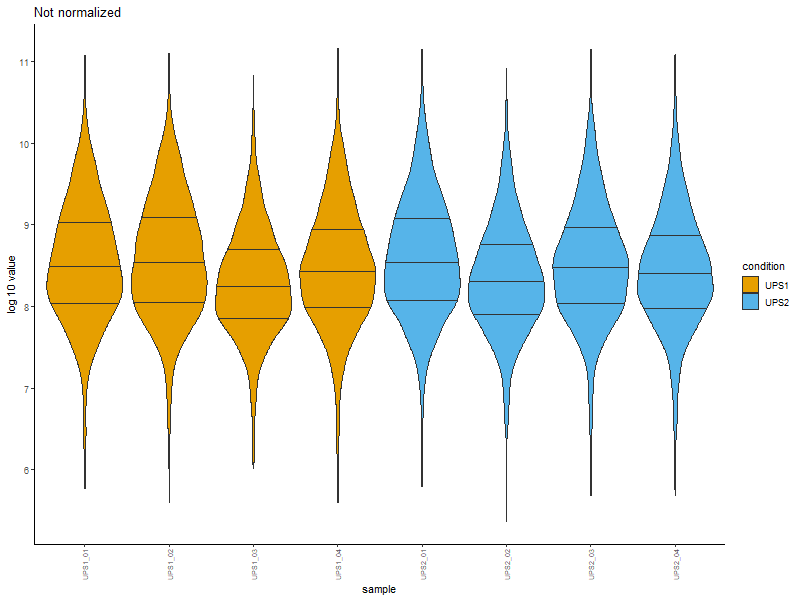

In [33]:
%%R -w 800 -h 600

prodat.med <- normalizeData(prodat)
prodat.quant <- normalizeData(prodat, norm.fun=limma::normalizeQuantiles)
plotSampleDistributions(prodat, title="Not normalized", fill="condition", method="violin")

In [34]:
%%R
res <- limmaDE(prodat, sig.level=0.05)

write.csv(res, file="./prodat_comp_res_filter.csv")

res <- limmaDE(prodat.med, sig.level=0.05)
write.csv(res, file="./prodat_med_comp_res_filter.csv")

res <- limmaDE(prodat.quant, sig.level=0.05)
write.csv(res, file="./prodat_quantile_comp_res_filter.csv")

head(res)

                    protein     logFC  AveExpr          t      P.Value
1 O00762ups|UBE2C_HUMAN_UPS -3.807714 28.95944  -5.530256 5.222490e-04
2  O76070ups|SYUG_HUMAN_UPS -5.301823 29.86594 -13.861528 6.050428e-07
3  P00167ups|CYB5_HUMAN_UPS -1.002748 32.03218  -4.663337 1.545924e-03
4  P00441ups|SODC_HUMAN_UPS -4.538227 29.56077 -10.918552 3.853081e-06
5 P00709ups|LALBA_HUMAN_UPS -2.683091 30.16471  -8.672924 2.191775e-05
6  P00915ups|CAH1_HUMAN_UPS  2.565373 33.49218   6.269427 2.243683e-04
     adj.P.Val           B significant mean_UPS1 mean_UPS2 ngood_UPS1
1 0.0305950860  0.05602872        TRUE  30.86329  27.05558          4
2 0.0002126725  6.76958040        TRUE  32.51685  27.21503          4
3 0.0881176444 -1.07970310       FALSE  32.53355  31.53080          4
4 0.0006286902  5.04241391        TRUE  31.82988  27.29165          4
5 0.0021011151  3.32519922        TRUE  31.50625  28.82316          4
6 0.0139174323  0.93745254        TRUE  32.20949  34.77487          4
  ngood_UPS2


In [35]:
proteus_median = pd.read_csv("./prodat_comp_res_filter.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

26
2
2068
13


In [36]:
proteus_median = pd.read_csv("./prodat_med_comp_res_filter.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

33
3
2067
6


In [37]:
proteus_median = pd.read_csv("./prodat_quantile_comp_res_filter.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

33
3
2067
6


In [51]:
import re
from collections import Counter

def clean_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    pep_seq = pep_seq.replace(".", "")
    return pattern.sub("", pep_seq)

def modified_PeptideSequence(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t_pep_seq = pep_seq.replace(".", "").replace("Acetyl", "ac").replace("Carbamidomethyl", "ca").replace("Oxidation", "ox")
    t_pep_seq = "_" + t_pep_seq + "_"

def get_modifications(pep_seq):
    pattern = re.compile(r"\(.*?\)")
    t = ""
    modifications = re.findall(pattern, pep_seq)
    if len(modifications) == 0:
        return "Unmodified"
    c = Counter(modifications)
    for key, value in c.items():
        if value == 1:
            c[key] = ""
        else:
            c[key] = str(c[key]) + " "
    modifications = ",".join(set(modifications))
    if "(Acetyl)" in c:
        modifications = modifications.replace("(Acetyl)", c["(Acetyl)"] + "Acetyl (Protein N-term)")
    if "(Carbamidomethyl)" in c:
        modifications = modifications.replace("(Carbamidomethyl)", c["(Carbamidomethyl)"] + "Carbamidomethyl (C)")
    if "(Oxidation)" in c:
        modifications = modifications.replace("(Oxidation)", c["(Oxidation)"] + "Oxidation (M)")
        
    return modifications

def get_experiment(row):
    return "_".join(row["Reference"].split(".")[0].split("_")[-2:])

evi = pd.DataFrame(None, columns=['sequence', 'modified_sequence', 'modifications', 'protein_group', 
                                  'protein', 'experiment', 'charge', 'reverse', 'contaminant', 'intensity'])
quantms = pd.read_csv("./PXD000279_no_shared_unique_3.csv", sep=',', header=0)

quantms = quantms[-quantms['ProteinName'].str.contains("DECOY_")]
evi['sequence'] = quantms.apply(lambda x: clean_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modified_sequence'] = quantms.apply(lambda x: modified_PeptideSequence(x['PeptideSequence']), axis=1)
evi['modifications'] = quantms.apply(lambda x: get_modifications(x['PeptideSequence']), axis=1)
evi['protein_group'] = quantms['ProteinName']
evi['protein'] = quantms['ProteinName']
evi['experiment'] = quantms.apply(lambda x: get_experiment(x), axis=1)
evi['charge'] = quantms['PrecursorCharge']
evi['intensity'] = quantms['Intensity']
evi.to_csv("evi_unique3.txt", sep='\t', index=False)

metadata = pd.DataFrame(None, columns=['experiment', 'measure', 'sample', 'condition', 'replicate'])
metadata['experiment'] = ['UPS1_01', 'UPS1_02', 'UPS1_03',
       'UPS1_04', 'UPS2_01', 'UPS2_02','UPS2_03', 'UPS2_04']
metadata['measure'] = ['Intensity'] * 8
metadata['sample'] = ['UPS1_01', 'UPS1_02', 'UPS1_03',
       'UPS1_04', 'UPS2_01', 'UPS2_02','UPS2_03', 'UPS2_04']
metadata['condition'] = ['UPS1', 'UPS1', 'UPS1','UPS1', 'UPS2', 'UPS2','UPS2', 'UPS2']
metadata['replicate'] = [1, 2, 3, 4] * 2
metadata.to_csv("metadata_unique3.txt", sep="\t", index=False)

In [52]:
%%R

library(proteus)

evi = read.csv("evi_unique3.txt", sep="\t", header=TRUE)
meta = read.csv("metadata_unique3.txt", sep="\t", header=TRUE)
pepdat <- makePeptideTable(evi, meta)
summary(pepdat)


*** Basic statistics ***

  content = peptide
  experiment type = label-free
  number of samples = 8
  number of conditions = 2
  number of peptides = 22877
  samples = UPS1_01, UPS1_02, UPS1_03, UPS1_04, UPS2_01, UPS2_02, UPS2_03, UPS2_04
  conditions = UPS1, UPS2

*** Data processing ***

  evidence columns used = Intensity
  sequence = 'Sequence'
  protein = 'Leading razor protein'
  normalization = identity


In [53]:
%%R

prodat <- makeProteinTable(pepdat)
head(prodat$tab)

                             UPS1_01    UPS1_02    UPS1_03    UPS1_04
O00762ups|UBE2C_HUMAN_UPS 1405555367 2465267773 1398198992 2624523882
O76070ups|SYUG_HUMAN_UPS  8374320000 8310648000 1485911757 8592413697
P00167ups|CYB5_HUMAN_UPS  7237330000 7968457133 2695331300 7032960000
P00441ups|SODC_HUMAN_UPS  4898760133 5437914533 1936543590 3496641267
P00709ups|LALBA_HUMAN_UPS 3696774000 3669703000 1440633440 3850955100
P00915ups|CAH1_HUMAN_UPS  8299357007 7554906693 1107202417 6363305860
                              UPS2_01     UPS2_02     UPS2_03     UPS2_04
O00762ups|UBE2C_HUMAN_UPS    52321160   160094800   465433800    85820640
O76070ups|SYUG_HUMAN_UPS    192869227   164200040   141290167   127114877
P00167ups|CYB5_HUMAN_UPS   4514579300  1959635900  2901376533  2629963803
P00441ups|SODC_HUMAN_UPS    239565250   141623180    78962700   261807467
P00709ups|LALBA_HUMAN_UPS   975680830   223541257   520962520   380500700
P00915ups|CAH1_HUMAN_UPS  37557116233 21317133333 32544200547 2988

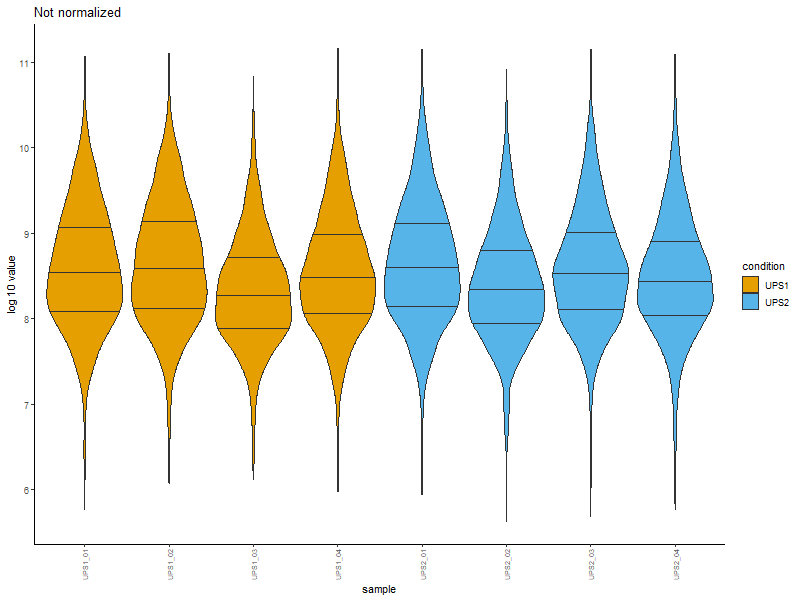

In [54]:
%%R -w 800 -h 600

prodat.med <- normalizeData(prodat)
prodat.quant <- normalizeData(prodat, norm.fun=limma::normalizeQuantiles)
plotSampleDistributions(prodat, title="Not normalized", fill="condition", method="violin")

In [55]:
%%R
res <- limmaDE(prodat, sig.level=0.05)

write.csv(res, file="./prodat_comp_res_filter_unique3.csv")

res <- limmaDE(prodat.med, sig.level=0.05)
write.csv(res, file="./prodat_med_comp_res_filter_unique3.csv")

res <- limmaDE(prodat.quant, sig.level=0.05)
write.csv(res, file="./prodat_quantile_comp_res_filter_unique3.csv")

head(res)

                    protein     logFC  AveExpr          t      P.Value
1 O00762ups|UBE2C_HUMAN_UPS -3.801464 28.96661  -5.616319 4.478771e-04
2  O76070ups|SYUG_HUMAN_UPS -5.310722 29.86801 -14.151879 4.468125e-07
3  P00167ups|CYB5_HUMAN_UPS -1.001306 32.03571  -4.800296 1.241952e-03
4  P00441ups|SODC_HUMAN_UPS -4.542445 29.56381 -10.783773 3.790289e-06
5 P00709ups|LALBA_HUMAN_UPS -2.690645 30.17166  -9.005827 1.508406e-05
6  P00915ups|CAH1_HUMAN_UPS  2.559425 33.49487   6.434155 1.762322e-04
     adj.P.Val          B significant mean_UPS1 mean_UPS2 ngood_UPS1 ngood_UPS2
1 0.0237001646  0.1687665        TRUE  30.86734  27.06587          4          4
2 0.0001418630  7.0789723        TRUE  32.52337  27.21265          4          4
3 0.0639437536 -0.9015173       FALSE  32.53637  31.53506          4          4
4 0.0005157501  5.0536784        TRUE  31.83503  27.29259          4          4
5 0.0013867861  3.6769468        TRUE  31.51699  28.82634          4          4
6 0.0098741883  1.14490

In [56]:
proteus_median = pd.read_csv("./prodat_comp_res_filter_unique3.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

28
2
1864
11


In [57]:
proteus_median = pd.read_csv("./prodat_med_comp_res_filter_unique3.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

33
3
1863
6


In [58]:
proteus_median = pd.read_csv("./prodat_quantile_comp_res_filter_unique3.csv", header=0, sep=",", index_col=0)
proteus_median.dropna(subset=["logFC", "P.Value"], how="any", inplace=True)
positive =  proteus_median[(abs(proteus_median["logFC"]) >1) &(proteus_median["adj.P.Val"] <0.05) ]
negative = proteus_median[(abs(proteus_median["logFC"]) <=1) | (proteus_median["adj.P.Val"] >=0.05) ]


TP = len(positive[positive["protein"].str.contains("|".join(difference_ups))])
FP = len(positive) - TP

FN = len(negative[negative["protein"].str.contains("|".join(difference_ups))])
TN = len(negative) - FN

print(TP)
print(FP)
print(TN)
print(FN)

33
3
1863
6
